# **Feature Engineering Notebook**

## Objectives

* Engineer features for Regression

## Inputs

* inputs/datasets/cleaned/TrainSet.csv
* inputs/datasets/cleaned/TestSet.csv

## Outputs

* outputs\datasets\engineered\TrainSet_Engineered.csv
* outputs\datasets\engineered\TestSet_Engineered.csv
* generate a list with variables to engineer

## Overview

This notebook covers the full feature engineering process applied to the cleaned housing dataset. Feature engineering is a critical step in preparing the data for machine learning, as it transforms raw variables into a format that improves the model’s ability to learn patterns. 

We will address:
- Enconding of categorical features
- Normalization of skewed numerical features
- Evaluation of transformation effects via visualization


---

# Change working directory

* We are assuming you will store the notebooks in a subfolder, therefore when running the notebook in the editor, you will need to change the working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with `os.getcwd()`

In [1]:
import os
current_dir = os.getcwd()
current_dir

'c:\\Users\\Arthur\\OneDrive\\Documentos\\Code Institute\\PP5\\PP5-heritage-housing-issues-ml\\jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* `os.path.dirname()` gets the parent directory
* `os.chir()` defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
print("New working directory set to:", os.getcwd())

New working directory set to: c:\Users\Arthur\OneDrive\Documentos\Code Institute\PP5\PP5-heritage-housing-issues-ml


---

# Load Cleaned Data

Train Set

In [4]:
import pandas as pd
train_set_path = "outputs/datasets/cleaned/TrainSetCleaned.csv"
TrainSet = pd.read_csv(train_set_path)
TrainSet.head(3)

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,GarageArea,GarageFinish,GarageYrBlt,...,LotArea,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,YearBuilt,YearRemodAdd,SalePrice
0,1314,0.0,3.0,No,922,Rec,392,294,RFn,1957.0,...,8400,70.0,0.0,0,6,5,1314,1957,1957,145000
1,799,772.0,3.0,No,0,Unf,799,380,RFn,1993.0,...,7837,59.0,0.0,40,7,6,799,1993,1994,178000
2,796,0.0,2.0,No,0,Unf,796,0,NaN,NaN,...,8777,67.0,0.0,0,7,5,796,1910,1950,85000


Test Set

In [5]:
test_set_path = 'outputs/datasets/cleaned/TestSetCleaned.csv'
TestSet = pd.read_csv(test_set_path)
TestSet.head(3)

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,GarageArea,GarageFinish,GarageYrBlt,...,LotArea,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,YearBuilt,YearRemodAdd,SalePrice
0,1068,0.0,3.0,No,663,GLQ,396,264,RFn,1963.0,...,8414,70.0,0.0,0,8,6,1059,1963,2003,154500
1,1500,NaN,3.0,Av,1032,GLQ,431,712,RFn,1994.0,...,12256,98.0,362.0,32,5,8,1463,1994,1995,325000
2,1028,NaN,2.0,No,0,Unf,1008,360,Unf,1927.0,...,8960,56.0,0.0,0,6,5,1008,1927,1950,115000


# Data Exploration

In [6]:
from ydata_profiling import ProfileReport
pandas_report = ProfileReport(df=TrainSet, minimal=True)
pandas_report.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

---

# Impute Missing Values

Before any modeling or transformation can occur, it's essential to address missing data. This ensures model compatibility and avoids distortions during encoding and scaling. 

We begin by identifying variables with missing values and apply suitable imputation strategies based on the variable type and domain knowledge. Where relevant, we also add binary indicators to flag imputed values for potential predictive insight.
We apply imputation strategies based on data type and domain understanding.

We see that there are 64 instances of 'Zero' in `GarageArea` and 64 empty instances in `GarageYrBlt`, leading us to infer that the missing data in `GarageYrBlt` relates to the lack of a garage in that house.

We start by handling missing values before encoding or scaling. This includes:

- Creating binary flags for missing values (e.g. `GarageYrBlt_missing`)
- Using grouped median imputation for `LotFrontage` based on `Neighborhood`
- Using constant values (like `0` or `"None"`) for features where missingness signals absence
- Applying SimpleImputer to other features using strategies based on metadata

In [7]:
# Add missingness indicators
TrainSet['GarageYrBlt_missing'] = TrainSet['GarageYrBlt'].isna().astype(int)
TrainSet['LotFrontage_missing'] = TrainSet['LotFrontage'].isna().astype(int)

TestSet['GarageYrBlt_missing'] = TestSet['GarageYrBlt'].isna().astype(int)
TestSet['LotFrontage_missing'] = TestSet['LotFrontage'].isna().astype(int)

# Use global median for LotFrontage
lotfrontage_median = TrainSet['LotFrontage'].median()
TrainSet['LotFrontage'] = TrainSet['LotFrontage'].fillna(lotfrontage_median)
TestSet['LotFrontage'] = TestSet['LotFrontage'].fillna(lotfrontage_median)


## Imputation Plan

|Feature | Metadata Insight | Strategy  | Notes|
|--------|------------------|----------------------------|------|
|`LotFrontage`  | Linear feet of street connected to property | Median | Group median |
|`GarageYrBlt`  | Year garage was built (1900–2010); missing if no garage | Fill with `0` | 0 clearly means no garage (can also flag with new feature if needed)|
|`2ndFlrSF`     | Square footage of second floor (0–2065); 0 is common | Fill with `0` | No imputation needed — zero is valid|
|`MasVnrArea`   | Masonry veneer area (0–1600); 0 means no veneer | Fill with `0` | 0 is semantically meaningful|
|`BedroomAbvGr` | Bedrooms above ground; 0–8 range | Median | Could also test for mode; median is fine|
|`BsmtExposure` | Exposure rating or `"None"` for no basement | Fill with `"None"` | Use `"None"` instead of "Missing" to match domain encoding|
|`BsmtFinType1` | Finish type or `"None"` if no basement | Fill with `"None"` | `"None"` is an actual category in metadata|
|`GarageFinish` | Garage interior finish or `"None"` if no garage | Fill with `"None"` | Use `"None"` for clarity and alignment with domain semantics|

In [8]:
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

# Columns to impute
numerical_impute_zero = ['2ndFlrSF', 'MasVnrArea', 'GarageYrBlt']
numerical_impute_median = ['BedroomAbvGr']
categorical_fill_none = ['BsmtExposure', 'BsmtFinType1', 'GarageFinish']

# Combine for full reference
all_imputed_cols = numerical_impute_zero + numerical_impute_median + categorical_fill_none
passthrough_cols = [col for col in TrainSet.columns if col not in all_imputed_cols]

# Create imputers
zero_imputer = SimpleImputer(strategy='constant', fill_value=0)
median_imputer = SimpleImputer(strategy='median')
cat_imputer = SimpleImputer(strategy='constant', fill_value='None')

# Column transformer
imputer_transformer = ColumnTransformer(transformers=[
    ('num_zero', zero_imputer, numerical_impute_zero),
    ('num_median', median_imputer, numerical_impute_median),
    ('cat_fill', cat_imputer, categorical_fill_none)
], remainder='passthrough')

# Fit and transform
TrainSet_array = imputer_transformer.fit_transform(TrainSet)
TestSet_array = imputer_transformer.transform(TestSet)

# Combine column names
final_columns = all_imputed_cols + passthrough_cols

# Create DataFrames
TrainSet_imputed = pd.DataFrame(TrainSet_array, columns=final_columns)
TestSet_imputed = pd.DataFrame(TestSet_array, columns=final_columns)

# Restore correct dtypes for imputed columns
for col in numerical_impute_zero + numerical_impute_median:
    TrainSet_imputed[col] = pd.to_numeric(TrainSet_imputed[col], downcast="integer")
    TestSet_imputed[col] = pd.to_numeric(TestSet_imputed[col], downcast="integer")

for col in categorical_fill_none:
    TrainSet_imputed[col] = TrainSet_imputed[col].astype("object")
    TestSet_imputed[col] = TestSet_imputed[col].astype("object")

# Restore correct dtypes for passthrough columns
for col in passthrough_cols:
    orig_dtype = TrainSet[col].dtype
    TrainSet_imputed[col] = TrainSet_imputed[col].astype(orig_dtype)
    TestSet_imputed[col] = TestSet_imputed[col].astype(orig_dtype)


### Preview Results After Imputation Step

In [9]:
TrainSet_imputed.head()

,2ndFlrSF,MasVnrArea,GarageYrBlt,BedroomAbvGr,BsmtExposure,BsmtFinType1,GarageFinish,1stFlrSF,BsmtFinSF1,BsmtUnfSF,...,LotFrontage,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,YearBuilt,YearRemodAdd,SalePrice,GarageYrBlt_missing,LotFrontage_missing
0,0,0,1957,3,No,Rec,RFn,1314,922,392,...,70.0,0,6,5,1314,1957,1957,145000,0,0
1,772,0,1993,3,No,Unf,RFn,799,0,799,...,59.0,40,7,6,799,1993,1994,178000,0,0
2,0,0,0,2,No,Unf,None,796,0,796,...,67.0,0,7,5,796,1910,1950,85000,1,0
3,787,252,1939,3,No,ALQ,Unf,981,569,162,...,60.0,0,7,5,731,1937,1950,175000,0,0
4,665,0,1924,3,No,LwQ,Unf,1026,218,808,...,50.0,0,6,5,1026,1924,1950,127000,0,0


### Check for remaining missing values

In [10]:
print("Remaining missing values in TrainSet:")
print(TrainSet_imputed.isnull().sum().sort_values(ascending=False).head())
print("Remaining missing values in TestSet:")
print(TestSet_imputed.isnull().sum().sort_values(ascending=False).head())

Remaining missing values in TrainSet:
2ndFlrSF               0
MasVnrArea             0
GarageYrBlt_missing    0
SalePrice              0
YearRemodAdd           0
dtype: int64
Remaining missing values in TestSet:
2ndFlrSF               0
MasVnrArea             0
GarageYrBlt_missing    0
SalePrice              0
YearRemodAdd           0
dtype: int64


### Confirm new flags exist

In [11]:
print("\nColumns added as missingness flags:")
print([col for col in TrainSet_imputed.columns if '_missing' in col])


Columns added as missingness flags:
['GarageYrBlt_missing', 'LotFrontage_missing']


### Convert integer columns into int64

In [12]:
for df in [TrainSet_imputed, TestSet_imputed]:
    int_columns = df.select_dtypes(include=['int8', 'int16', 'int32']).columns
    df[int_columns] = df[int_columns].astype('int64')
print("Conversion to int64 completed.")

Conversion to int64 completed.


---

## Post-Imputation Correlation & PPS Check

Now that we've imputed missing values and added flags, we reassess the feature relationships.

This helps us:
- Re-confirm top predictors of `SalePrice`
- Detect any new multicollinearity
- Spot newly valuable features (e.g. missingness indicators)

We'll examine both:
- **Pearson/Spearman correlation** (for linear and monotonic relationships)
- **Power Predictive Score (PPS)** (for general predictive strength)
NOTE

In [13]:
# 1. Preview column data types
print("Column data types after imputation:")
print(TrainSet_imputed.dtypes.value_counts())

# 2. Get object columns for review
object_cols = TrainSet_imputed.select_dtypes(include='object').columns.tolist()
print(f"\nObject-type columns to review ({len(object_cols)}):")
print(object_cols)

# 3. Get numeric columns for review
numeric_cols = TrainSet_imputed.select_dtypes(include=['int64', 'float64']).columns.tolist()
print(f"\nNumeric-type columns to review ({len(numeric_cols)}):")
print(numeric_cols)


Column data types after imputation:
int64      19
object      4
float64     1
Name: count, dtype: int64

Object-type columns to review (4):
['BsmtExposure', 'BsmtFinType1', 'GarageFinish', 'KitchenQual']

Numeric-type columns to review (20):
['2ndFlrSF', 'MasVnrArea', 'GarageYrBlt', 'BedroomAbvGr', '1stFlrSF', 'BsmtFinSF1', 'BsmtUnfSF', 'GarageArea', 'GrLivArea', 'LotArea', 'LotFrontage', 'OpenPorchSF', 'OverallCond', 'OverallQual', 'TotalBsmtSF', 'YearBuilt', 'YearRemodAdd', 'SalePrice', 'GarageYrBlt_missing', 'LotFrontage_missing']


Then we save the imputed datasets 

In [15]:
# Create folder if not exists
os.makedirs("outputs/datasets/engineered", exist_ok=True)

# Save Train and Test Sets after imputation and feature transformations
TrainSet_imputed.to_csv("outputs/datasets/engineered/TrainSet_Engineered.csv", index=False)
TestSet_imputed.to_csv("outputs/datasets/engineered/TestSet_Engineered.csv", index=False)

print("Engineered datasets saved successfully.")

Engineered datasets saved successfully.


---

# Evaluate Distribution Transformations

Now we assess whether **distribution transformations** (e.g. log, Yeo-Johnson) could help normalize features and benefit certain algorithms (like linear models or KNN).

We'll use a custom utility `FeatureEngineeringAnalysis` to preview the effect of various transformations.


### Custom Function

In [16]:
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings
from feature_engine import transformation as vt
from feature_engine.outliers import Winsorizer
from feature_engine.encoding import OrdinalEncoder
sns.set(style="whitegrid")
warnings.filterwarnings('ignore')

%matplotlib inline


def FeatureEngineeringAnalysis(df, analysis_type=None):
    """
    - used for quick feature engineering on numerical and categorical variables
    to decide which transformation can better transform the distribution shape
    - Once transformed, use a reporting tool, like ydata-profiling, to evaluate distributions
    """
    check_missing_values(df)
    allowed_types = ['numerical', 'ordinal_encoder', 'outlier_winsorizer']
    check_user_entry_on_analysis_type(analysis_type, allowed_types)
    list_column_transformers = define_list_column_transformers(analysis_type)

    # Loop in each variable and engineer the data according to the analysis type
    df_feat_eng = pd.DataFrame([])
    for column in df.columns:
        # create additional columns (column_method) to apply the methods
        df_feat_eng = pd.concat([df_feat_eng, df[column]], axis=1)
        for method in list_column_transformers:
            df_feat_eng[f"{column}_{method}"] = df[column]

        # Apply transformers in respective column_transformers
        df_feat_eng, list_applied_transformers = apply_transformers(
            analysis_type, df_feat_eng, column)

        # For each variable, assess how the transformations perform
        transformer_evaluation(
            column, list_applied_transformers, analysis_type, df_feat_eng)

    return df_feat_eng


def check_user_entry_on_analysis_type(analysis_type, allowed_types):
    """ Check analysis type """
    if analysis_type is None:
        raise SystemExit(
            f"You should pass analysis_type parameter as one of the following options: {allowed_types}")
    if analysis_type not in allowed_types:
        raise SystemExit(
            f"analysis_type argument should be one of these options: {allowed_types}")


def check_missing_values(df):
    if df.isna().sum().sum() != 0:
        raise SystemExit(
            f"There is a missing value in your dataset. Please handle that before getting into feature engineering.")


def define_list_column_transformers(analysis_type):
    """ Set suffix columns according to analysis_type"""
    if analysis_type == 'numerical':
        list_column_transformers = [
            "log_e", "log_10", "reciprocal", "power", "box_cox", "yeo_johnson"]

    elif analysis_type == 'ordinal_encoder':
        list_column_transformers = ["ordinal_encoder"]

    elif analysis_type == 'outlier_winsorizer':
        list_column_transformers = ['iqr']

    return list_column_transformers


def apply_transformers(analysis_type, df_feat_eng, column):
    for col in df_feat_eng.select_dtypes(include='category').columns:
        df_feat_eng[col] = df_feat_eng[col].astype('object')

    if analysis_type == 'numerical':
        df_feat_eng, list_applied_transformers = FeatEngineering_Numerical(
            df_feat_eng, column)

    elif analysis_type == 'outlier_winsorizer':
        df_feat_eng, list_applied_transformers = FeatEngineering_OutlierWinsorizer(
            df_feat_eng, column)

    elif analysis_type == 'ordinal_encoder':
        df_feat_eng, list_applied_transformers = FeatEngineering_CategoricalEncoder(
            df_feat_eng, column)

    return df_feat_eng, list_applied_transformers


def transformer_evaluation(column, list_applied_transformers, analysis_type, df_feat_eng):
    # For each variable, assess how the transformations perform
    print(f"* Variable Analyzed: {column}")
    print(f"* Applied transformation: {list_applied_transformers} \n")
    for col in [column] + list_applied_transformers:

        if analysis_type != 'ordinal_encoder':
            DiagnosticPlots_Numerical(df_feat_eng, col)

        else:
            if col == column:
                DiagnosticPlots_Categories(df_feat_eng, col)
            else:
                DiagnosticPlots_Numerical(df_feat_eng, col)

        print("\n")


def DiagnosticPlots_Categories(df_feat_eng, col):
    plt.figure(figsize=(4, 3))
    sns.countplot(data=df_feat_eng, x=col, palette=[
                  '#432371'], order=df_feat_eng[col].value_counts().index)
    plt.xticks(rotation=90)
    plt.suptitle(f"{col}", fontsize=30, y=1.05)
    plt.show()
    print("\n")


def DiagnosticPlots_Numerical(df, variable):
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    sns.histplot(data=df, x=variable, kde=True, element="step", ax=axes[0])
    stats.probplot(df[variable], dist="norm", plot=axes[1])
    sns.boxplot(x=df[variable], ax=axes[2])

    axes[0].set_title('Histogram')
    axes[1].set_title('QQ Plot')
    axes[2].set_title('Boxplot')
    fig.suptitle(f"{variable}", fontsize=30, y=1.05)
    plt.tight_layout()
    plt.show()


def FeatEngineering_CategoricalEncoder(df_feat_eng, column):
    list_methods_worked = []
    try:
        encoder = OrdinalEncoder(encoding_method='arbitrary', variables=[
                                 f"{column}_ordinal_encoder"])
        df_feat_eng = encoder.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_ordinal_encoder")

    except Exception:
        df_feat_eng.drop([f"{column}_ordinal_encoder"], axis=1, inplace=True)

    return df_feat_eng, list_methods_worked


def FeatEngineering_OutlierWinsorizer(df_feat_eng, column):
    list_methods_worked = []

    # Winsorizer iqr
    try:
        disc = Winsorizer(
            capping_method='iqr', tail='both', fold=1.5, variables=[f"{column}_iqr"])
        df_feat_eng = disc.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_iqr")
    except Exception:
        df_feat_eng.drop([f"{column}_iqr"], axis=1, inplace=True)

    return df_feat_eng, list_methods_worked


def FeatEngineering_Numerical(df_feat_eng, column):
    list_methods_worked = []

    # LogTransformer base e
    try:
        lt = vt.LogTransformer(variables=[f"{column}_log_e"])
        df_feat_eng = lt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_log_e")
    except Exception:
        df_feat_eng.drop([f"{column}_log_e"], axis=1, inplace=True)

    # LogTransformer base 10
    try:
        lt = vt.LogTransformer(variables=[f"{column}_log_10"], base='10')
        df_feat_eng = lt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_log_10")
    except Exception:
        df_feat_eng.drop([f"{column}_log_10"], axis=1, inplace=True)

    # ReciprocalTransformer
    try:
        rt = vt.ReciprocalTransformer(variables=[f"{column}_reciprocal"])
        df_feat_eng = rt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_reciprocal")
    except Exception:
        df_feat_eng.drop([f"{column}_reciprocal"], axis=1, inplace=True)

    # PowerTransformer
    try:
        pt = vt.PowerTransformer(variables=[f"{column}_power"])
        df_feat_eng = pt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_power")
    except Exception:
        df_feat_eng.drop([f"{column}_power"], axis=1, inplace=True)

    # BoxCoxTransformer
    try:
        bct = vt.BoxCoxTransformer(variables=[f"{column}_box_cox"])
        df_feat_eng = bct.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_box_cox")
    except Exception:
        df_feat_eng.drop([f"{column}_box_cox"], axis=1, inplace=True)

    # YeoJohnsonTransformer
    try:
        yjt = vt.YeoJohnsonTransformer(variables=[f"{column}_yeo_johnson"])
        df_feat_eng = yjt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_yeo_johnson")
    except Exception:
        df_feat_eng.drop([f"{column}_yeo_johnson"], axis=1, inplace=True)

    return df_feat_eng, list_methods_worked


### Categorical Encoding - Ordinal: replaces categories with ordinal numbers

* Step 1: Select variable(s)

In [17]:
categorical_features = ['BsmtExposure', 'BsmtFinType1', 'GarageFinish', 'KitchenQual']
print("Categorical features:", categorical_features)

Categorical features: ['BsmtExposure', 'BsmtFinType1', 'GarageFinish', 'KitchenQual']


* Step 2: Create a separate DataFrame, with your variable(s)

In [18]:
df_engineering = TrainSet_imputed[categorical_features].copy()
df_engineering.head(5)

,BsmtExposure,BsmtFinType1,GarageFinish,KitchenQual
0,No,Rec,RFn,TA
1,No,Unf,RFn,TA
2,No,Unf,None,TA
3,No,ALQ,Unf,Gd
4,No,LwQ,Unf,Gd


* Step 3: Create engineered variables(s) by applying the transformation(s), assess engineered variables distribution and select the most suitable method for each variable.

* Variable Analyzed: BsmtExposure
* Applied transformation: ['BsmtExposure_ordinal_encoder'] 



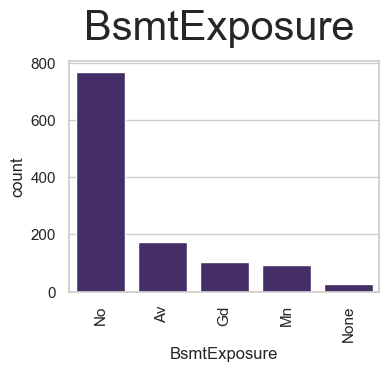

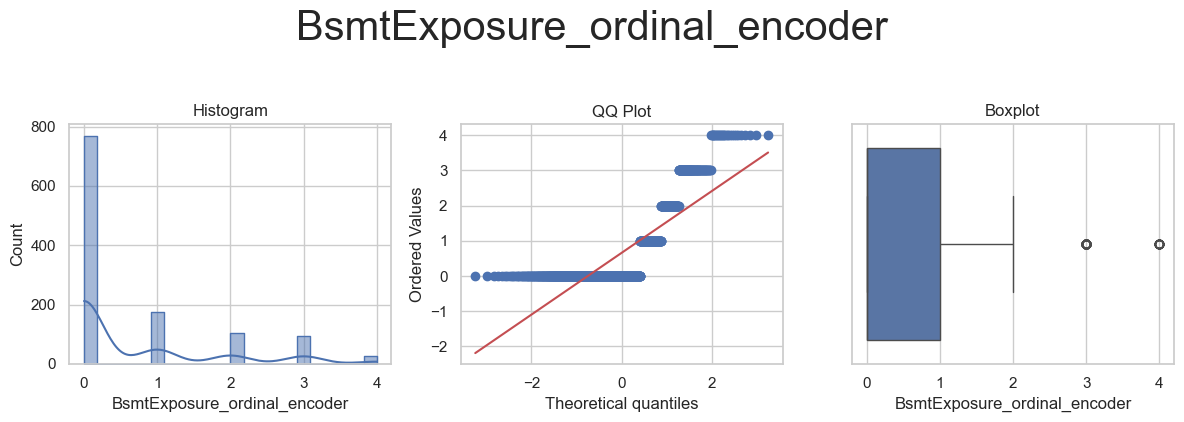



* Variable Analyzed: BsmtFinType1
* Applied transformation: ['BsmtFinType1_ordinal_encoder'] 



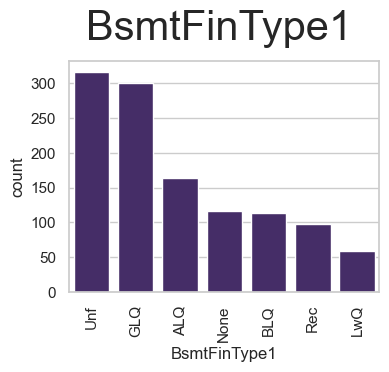

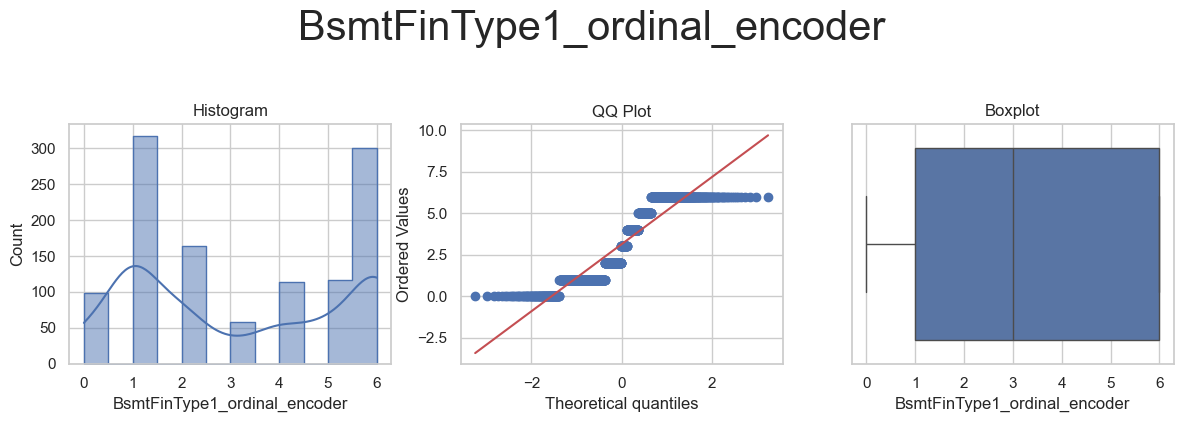



* Variable Analyzed: GarageFinish
* Applied transformation: ['GarageFinish_ordinal_encoder'] 



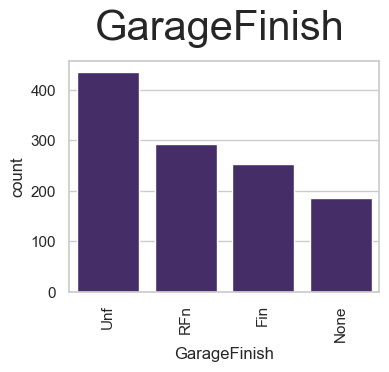

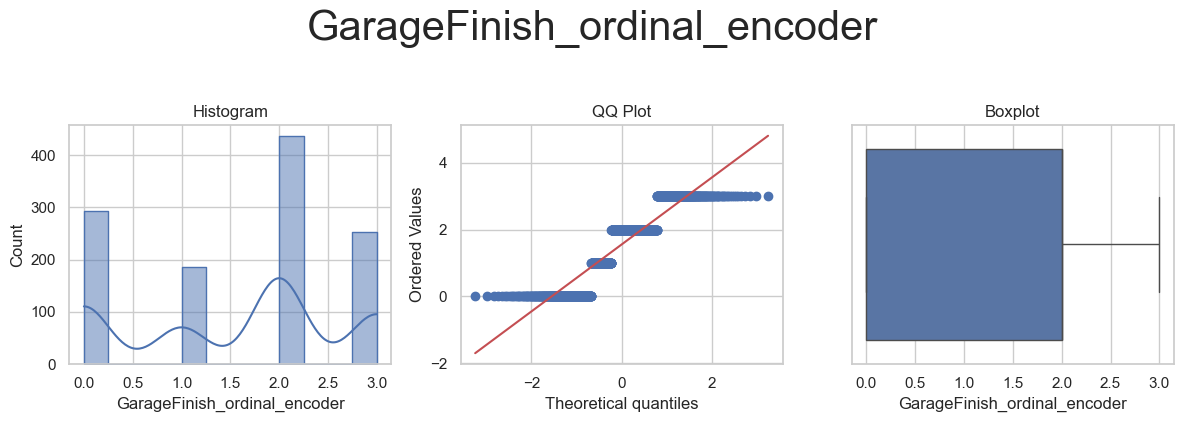



* Variable Analyzed: KitchenQual
* Applied transformation: ['KitchenQual_ordinal_encoder'] 



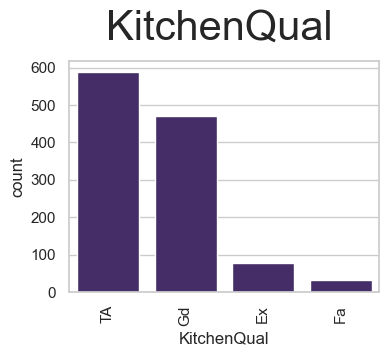

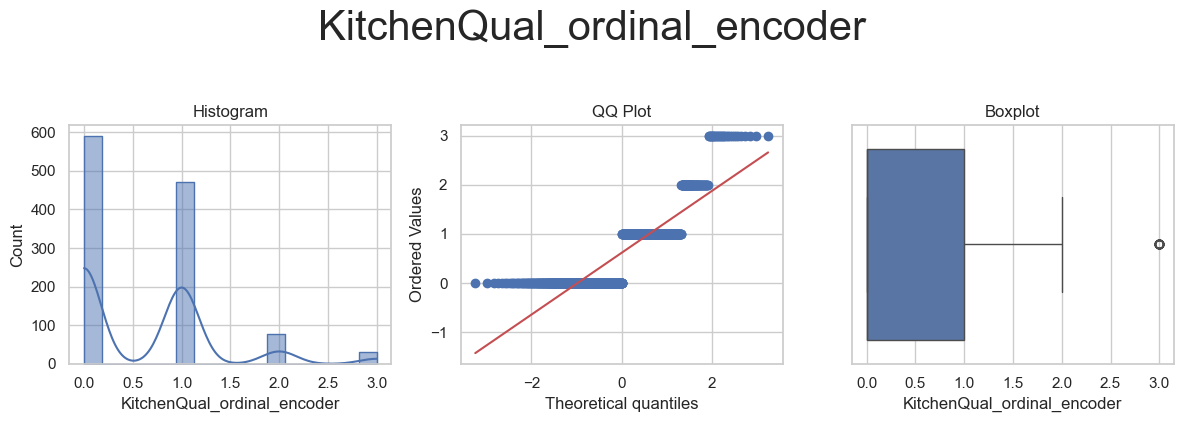

In [19]:
# Pass only the original categorical features to avoid conflicts with already transformed columns
df_engineering = FeatureEngineeringAnalysis(df=TrainSet_imputed[categorical_features], analysis_type='ordinal_encoder')

For all variables, the transformation is effective, since it converted categories to numbers.

* Step 4 - Apply the selected transformation to the Train and Test set
    1. Create a transformer
    2. Fit_transform into TrainSet
    3. Transform into TestSet 

In [20]:
encoder = OrdinalEncoder(encoding_method='arbitrary', variables = categorical_features)
TrainSet_imputed = encoder.fit_transform(TrainSet_imputed)
TestSet_imputed = encoder.transform(TestSet_imputed)

print("* Categorical encoding - ordinal transformation done!")

* Categorical encoding - ordinal transformation done!


### Numerical Transformation

#### Step 1: Select Features to Analyze
Since there many numerical features, we should prioritize:

A. Features highly correlated with SalePrice
From your correlation analysis, these are likely candidates:

|  Variable   |  Why Analyze?                                               |
|-------------|-------------------------------------------------------------|
| GrLivArea   | Often skewed right, strong correlation                      |
| GarageArea  | May benefit from log transformation                         |
| TotalBsmtSF | Can vary widely and often right-skewed                      |
|  1stFlrSF   | Similar to above                                            |
| OverallQual | Ordinal, might not need transformation but worth visualizing|

B. New or imputed variables

|Variable    | Why Analyze?                            |
|------------|-----------------------------------------|
|LotFrontage | We imputed it — so let's check its shape|
|MasVnrArea  | Many zeroes — investigate transformation|
|YearBuilt   | Time-based but numeric                  |
|OpenPorchSF | Could have long tail                    |

In [28]:
top_numerical_features = [
    'GrLivArea',
    'GarageArea',
    'TotalBsmtSF',
    '1stFlrSF',
    'LotFrontage',
    'MasVnrArea',
    'OpenPorchSF',
    'YearBuilt'
]
print("Top Numerical variables:", top_numerical_features)

Top Numerical variables: ['GrLivArea', 'GarageArea', 'TotalBsmtSF', '1stFlrSF', 'LotFrontage', 'MasVnrArea', 'OpenPorchSF', 'YearBuilt']


* Step 2: Create a separate DataFrame, with your variable(s)

In [29]:
df_engineering = TrainSet_imputed[top_numerical_features].copy()
df_engineering.head(3)

,GrLivArea,GarageArea,TotalBsmtSF,1stFlrSF,LotFrontage,MasVnrArea,OpenPorchSF,YearBuilt
0,1314,294,1314,1314,70.0,0,0,1957
1,1571,380,799,799,59.0,0,40,1993
2,796,0,796,796,67.0,0,0,1910


* Step 3: Create engineered variables(s) by applying the transformation(s), assess engineered variables distribution and select the most suitable method

In [ ]:
df_engineering = FeatureEngineeringAnalysis(df=df_engineering, analysis_type='numerical')

### How We Chose Which Transformations to Apply

Each numerical variable was evaluated across multiple transformation methods using three visual diagnostics:
- **Histogram**: checked for symmetry and bell-shaped distribution
- **QQ Plot**: checked alignment with the diagonal (indicating normality)
- **Boxplot**: checked for outlier compression and spread

We selected the transformation that yielded the best visual improvement while preserving interpretability. Below is a summary of the selected transformations:

| Variable        | Transformation Applied | Reasoning                                                                 |
|-----------------|------------------------|---------------------------------------------------------------------------|
| `GrLivArea`     | `log_e`                | Reduced right-skew and improved normality visually                        |
| `GarageArea`    | `yeo_johnson`          | Handles zero values, improved symmetry                                   |
| `1stFlrSF`      | `log_10`               | Significantly improved QQ plot and histogram                             |
| `TotalBsmtSF`   | `power`                | Strong visual improvement in distribution shape                          |
| `LotFrontage`   | `yeo_johnson`          | Smoothed outliers and improved bell-shaped symmetry                      |
| `OverallQual`   | None                   | Ordinal variable, distribution already clean and interpretable           |
| `YearBuilt`     | None                   | Discrete time-based variable; transformations distorted interpretability |

Transformations not selected (like `reciprocal` or `box_cox`) were either less interpretable or introduced new artifacts.


### SmartCorrelatedSelection Variables

* Step 1: Select variable(s): for this transformer, you don't need to select variables, since you need all variables for this transformer

* Step 2: Create a separate DataFrame, with your variable(s)

In [31]:
df_engineering = TrainSet_imputed.copy()
df_engineering.head(5)

,2ndFlrSF,MasVnrArea,GarageYrBlt,BedroomAbvGr,BsmtExposure,BsmtFinType1,GarageFinish,1stFlrSF,BsmtFinSF1,BsmtUnfSF,...,LotFrontage,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,YearBuilt,YearRemodAdd,SalePrice,GarageYrBlt_missing,LotFrontage_missing
0,0,0,1957,3,0,0,0,1314,922,392,...,70.0,0,6,5,1314,1957,1957,145000,0,0
1,772,0,1993,3,0,1,0,799,0,799,...,59.0,40,7,6,799,1993,1994,178000,0,0
2,0,0,0,2,0,1,1,796,0,796,...,67.0,0,7,5,796,1910,1950,85000,1,0
3,787,252,1939,3,0,2,2,981,569,162,...,60.0,0,7,5,731,1937,1950,175000,0,0
4,665,0,1924,3,0,3,2,1026,218,808,...,50.0,0,6,5,1026,1924,1950,127000,0,0


* Step 3: Create engineered variables(s) applying the transformation(s)

In [32]:
from feature_engine.selection import SmartCorrelatedSelection
corr_sel = SmartCorrelatedSelection(variables=None, method="spearman", threshold=0.6, selection_method="variance")

corr_sel.fit_transform(df_engineering)
corr_sel.correlated_feature_sets_

[{'2ndFlrSF', 'GrLivArea'},
 {'GarageArea',
  'GarageYrBlt',
  'OverallQual',
  'SalePrice',
  'YearBuilt',
  'YearRemodAdd'},
 {'1stFlrSF', 'TotalBsmtSF'}]

In [33]:
corr_sel.features_to_drop_

['2ndFlrSF',
 'GarageYrBlt',
 '1stFlrSF',
 'GarageArea',
 'OverallQual',
 'YearBuilt',
 'YearRemodAdd']

# Push cleaned data to Repo

You can now push the changes to your GitHub repository, using the Git commands (git add, git commit, git push).

# Conclusions and Next Steps

### Key Outcomes
- All missing values were imputed using context-appropriate strategies.
- A selection of transformations was done via visual diagnostics (histogram, QQ plot, boxplot). Several numerical features were temporarily transformed using techniques like `log`, `power`, and `yeo-johnson` and then analysed if they successful in reducing skewness and improving normality
- SmartCorrelatedSelection indicated several features to be dropped with a threshold of 0.6

    |Features to be dropped|
    |------------|
    |`2ndFlrSF`|
    |`GarageYrBlt`|
    |`1stFlrSF`|
    |`GarageArea`|
    |`OverallQual`|
    |`YearBuilt`|
    |`YearRemodAd`|

### Next Steps

- Conduct feature scaling if required (depending on the chosen algorithm).
- Train baseline models and compare performance (e.g., Linear Regression, Random Forest).
- Apply feature importance analysis post-modeling to validate choices made during feature engineering.